# Result Analysis

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
import torch
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir'),
 'figdir': PosixPath('../data/workdir/figdir'),
 'raw_csv': PosixPath('../data/mimic_icu_pred_raw_dataset.csv'),
 'proc_csv': PosixPath('../data/mimic_icu_pred_proc_dataset.csv'),
 'cols': ['imminent_label',
  'discharge_label',
  'scispacy_note',
  'charttime',
  'intime'],
 'dates': ['charttime', 'intime'],
 'imminent_threshold': {'lr': 0.47, 'rf': 0.32, 'gbm': 0.3},
 'discharge_threshold': {'lr': 0.48, 'rf': 0.37, 'gbm': 0.39}}

## 100 Run Performance Results

In [3]:
models = list(args.imminent_threshold.keys())

imminent_bams = {}
discharge_bams = {}

for model in models:
  with open(args.workdir/model/'imminent_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
  imminent_bams[model] = BinaryAvgMetrics(targs, preds, probs)
    
  with open(args.workdir/model/'discharge_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)    
  discharge_bams[model] = BinaryAvgMetrics(targs, preds, probs)    

imminent_metrics = {}
discharge_metrics = {}

for key in imminent_bams.keys():
  imminent_metrics[key] = []
  discharge_metrics[key] = []
  for i in range(len(imminent_bams[key].get_avg_metrics())):
    imminent_metrics[key].append(imminent_bams[key].get_avg_metrics().iloc[i]['Value'])
  for i in range(len(discharge_bams[key].get_avg_metrics())):
    discharge_metrics[key].append(discharge_bams[key].get_avg_metrics().iloc[i]['Value'])    

imminent_metrics = pd.DataFrame(imminent_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
discharge_metrics = pd.DataFrame(discharge_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])

In [4]:
imminent_metrics

,lr,rf,gbm
sensitivity,89.3,82.3,81.7
specificity,62.2,73.3,74.4
ppv,42.2,48.8,49.6
auroc,84.2,85.7,86.2
npv,95.0,93.1,93.0
f1,57.3,61.2,61.7


In [5]:
discharge_metrics

,lr,rf,gbm
sensitivity,71.4,78.2,79.4
specificity,63.7,61.0,63.0
ppv,53.1,53.6,55.3
auroc,74.9,78.6,80.1
npv,79.4,82.9,84.1
f1,60.9,63.6,65.2


Text(0.08, 0.5, 'True Positive Rate')

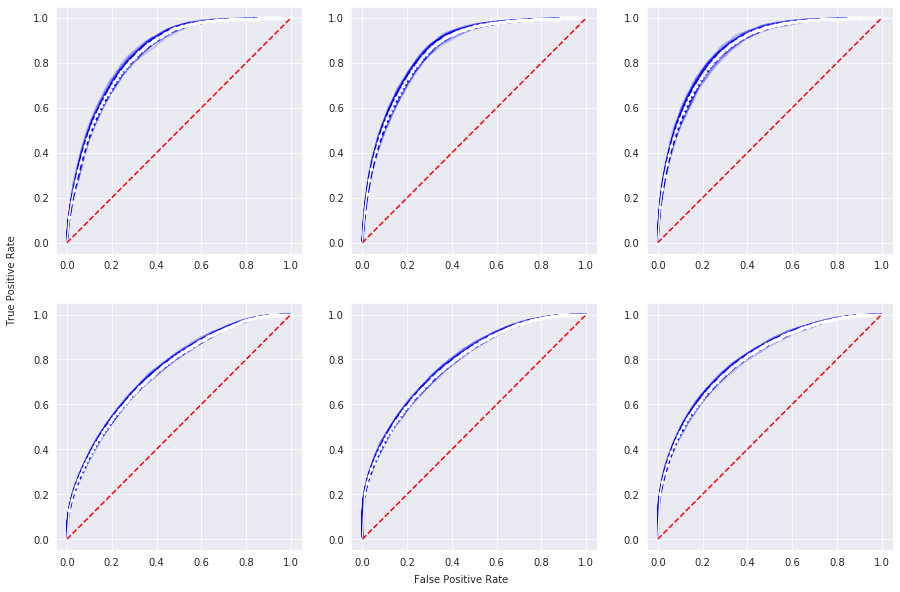

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_mean_roc(ax[0][0], imminent_bams['lr'].targs, imminent_bams['lr'].probs)
plot_mean_roc(ax[0][1], imminent_bams['rf'].targs, imminent_bams['rf'].probs)
plot_mean_roc(ax[0][2], imminent_bams['gbm'].targs, imminent_bams['gbm'].probs)

plot_mean_roc(ax[1][0], discharge_bams['lr'].targs, discharge_bams['lr'].probs)
plot_mean_roc(ax[1][1], discharge_bams['rf'].targs, discharge_bams['rf'].probs)
plot_mean_roc(ax[1][2], discharge_bams['gbm'].targs, discharge_bams['gbm'].probs)

fig.text(0.5, 0.08, 'False Positive Rate', ha='center')
fig.text(0.08, 0.5, 'True Positive Rate', va='center', rotation='vertical')

# plt.subplots_adjust(hspace = 0.2)

In [7]:
# fig.savefig(args.figdir/f'{model}_mean_roc.tif', dpi=300)

## Probability Plots

In [8]:
df = pd.read_csv(args.proc_csv, usecols=args.cols, parse_dates=args.dates)
df['relative_charttime'] = (df['charttime'] - df['intime'])

imminent_df = df.loc[(df['imminent_label'] != -1)][['scispacy_note', 'imminent_label', 'relative_charttime']].reset_index()
discharge_df = df[['scispacy_note', 'discharge_label', 'relative_charttime']].reset_index()

In [9]:
interval_hours=12
starting_day = -20
ending_day = -1

### Imminent ICU Admission

In [10]:
model = 'lr'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

model = 'rf'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

model = 'gbm'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

Text(0.08, 0.5, 'Probability')

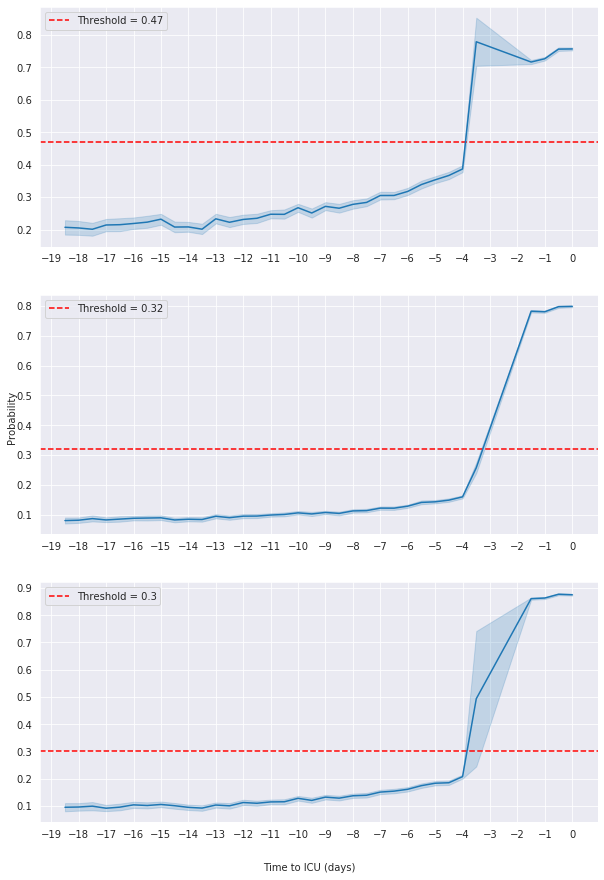

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plot_prob(ax[0], imminent_df, 'lr', args.imminent_threshold['lr'], starting_day, ending_day, interval_hours)
plot_prob(ax[1], imminent_df, 'rf', args.imminent_threshold['rf'], starting_day, ending_day, interval_hours)
plot_prob(ax[2], imminent_df, 'gbm', args.imminent_threshold['gbm'], starting_day, ending_day, interval_hours)

fig.text(0.5, 0.08, 'Time to ICU (days)', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', rotation='vertical')

### ICU Discharge

In [12]:
model = 'lr'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

model = 'rf'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

model = 'gbm'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

Text(0.08, 0.5, 'Probability')

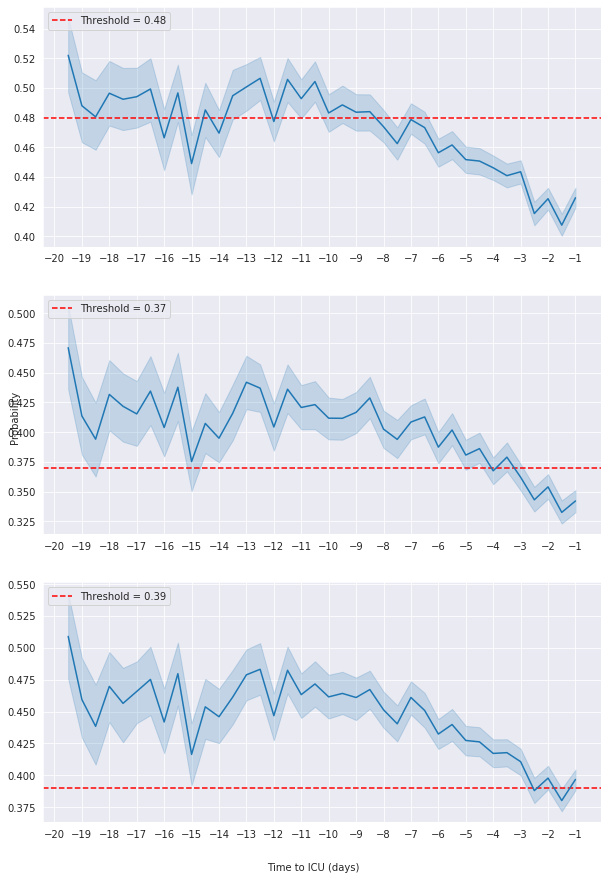

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plot_prob(ax[0], discharge_df, 'lr', args.discharge_threshold['lr'], starting_day, ending_day, interval_hours)
plot_prob(ax[1], discharge_df, 'rf', args.discharge_threshold['rf'], starting_day, ending_day, interval_hours)
plot_prob(ax[2], discharge_df, 'gbm', args.discharge_threshold['gbm'], starting_day, ending_day, interval_hours)

fig.text(0.5, 0.08, 'Time to ICU (days)', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', rotation='vertical')

## Word Clouds

### Imminent ICU Admission

In [14]:
scores = {}
feature_names = {}

model = 'lr'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.coef_[0]/clf.coef_[0].sum()

model = 'rf'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

model = 'gbm'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

(-0.5, 399.5, 399.5, -0.5)

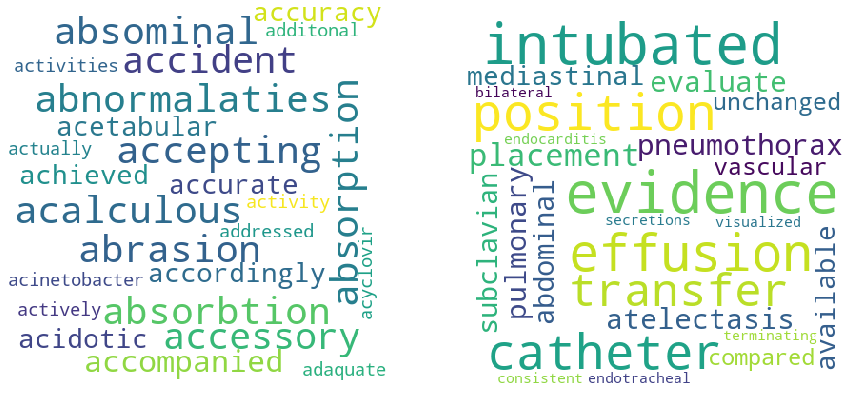

In [15]:
model = 'gbm'
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
neg, pos = get_wordcloud(feature_names[model], scores[model], n_words=25)
ax[0].imshow(neg)
ax[0].axis('off')
ax[1].imshow(pos)
ax[1].axis('off')

### ICU Discharge

In [16]:
scores = {}
feature_names = {}

model = 'lr'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.coef_[0]/clf.coef_[0].sum()

model = 'rf'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

model = 'gbm'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

(-0.5, 399.5, 399.5, -0.5)

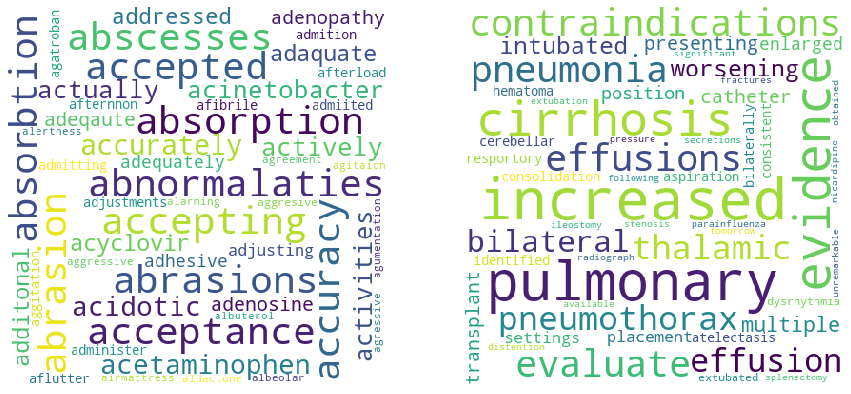

In [17]:
model = 'gbm'
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
neg, pos = get_wordcloud(feature_names[model], scores[model], n_words=50)
ax[0].imshow(neg)
ax[0].axis('off')
ax[1].imshow(pos)
ax[1].axis('off')

In [18]:
# fig.savefig(args.figdir/f'prob.tif', dpi=300)